In [18]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import blip_analysis as ba
import numpy as np
import pickle
from matplotlib.gridspec import GridSpec
from sklearn.decomposition import PCA
from copy import deepcopy
from sklearn.cluster import KMeans
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
import json
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
### Load in data
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [19]:
### Calculate the mean of the usrts
unit_usrt_j = np.concatenate((unit_usrt1[good_indexes], unit_usrt2[good_indexes], unit_usrt3[good_indexes]), axis=0)
mean_usrt1 = np.array([[i.mean() for i in j] for j in unit_usrt1[good_indexes]])
mean_usrt2 = np.array([[i.mean() for i in j] for j in unit_usrt2[good_indexes]])
mean_usrt3 = np.array([[i.mean() for i in j] for j in unit_usrt3[good_indexes]])
mean_all_usrt = np.concatenate((mean_usrt1, mean_usrt2, mean_usrt3), axis=0)
norm_mean_all_usrt = (mean_all_usrt - np.min(mean_all_usrt, axis=-1)[:, np.newaxis])/(np.max(mean_all_usrt, axis=-1)[:, np.newaxis] - np.min(mean_all_usrt, axis=-1)[: ,np.newaxis])
style_params = json.load(open('../Data/style_params.json', 'r'))

In [4]:
### Load in the fit models
diff_models1 = pickle.Unpickler(open('../Data/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Data/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Data/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Data/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Data/230320_conc_models1.pkl', 'rb')).load()
diff_models_j = np.concatenate((diff_models1, diff_models2, diff_models3), axis=0)



In [5]:
### Extract the bins
bins1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1]).mean(axis=1)
bins2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2]).mean(axis=1)
bins3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3]).mean(axis=1)

all_preds = [i.pred_resp for i in diff_models1] + [i.pred_resp for i in diff_models2] + [i.pred_resp for i in diff_models3]
all_trues = [i.true_resp for i in diff_models1] + [i.true_resp for i in diff_models2] + [i.true_resp for i in diff_models3]


In [6]:
### Apply PCA to the bins
pca1 = PCA(n_components=9)
fit_bins1 = pca1.fit_transform(bins1)
fit_1_pc12 = deepcopy(fit_bins1)
fit_1_pc12[:, 2:] = 0
bins_1_pc12 = pca1.inverse_transform(fit_1_pc12)


pca2 = PCA(n_components=9)
fit_bins2 = pca2.fit_transform(bins2)
fit_2_pc12 = fit_bins2.copy()
fit_2_pc12[:, 2:] = 0
bins_2_pc12 = pca2.inverse_transform(fit_2_pc12)

pca3 = PCA(n_components=9)
fit_bins3 = pca3.fit_transform(bins3)
fit_3_pc12 = fit_bins3.copy()
fit_3_pc12[:, 2:] = 0
bins_3_pc12 = pca3.inverse_transform(fit_3_pc12)

pca_all = PCA(n_components=9)
all_bins = np.concatenate([bins1 , bins2 , bins3], axis=0)
fit_bins_all = pca_all.fit_transform(all_bins)
fit_all_pc12 = fit_bins_all.copy()
fit_all_pc12[:, 2:] = 0
bins_all_pc12 = pca_all.inverse_transform(fit_all_pc12)

In [7]:
### Generate the predicted distributions along PC1 and PC2
pc1_exp_decay = np.abs([i - np.median(fit_bins_all[:, 0]) for i in fit_bins_all[:, 0]]).mean()
pc2_exp_decay = np.abs([i - np.median(fit_bins_all[:, 1]) for i in fit_bins_all[:, 1]]).mean()
rand1 = np.random.laplace(0, pc1_exp_decay, 10000)
rand2 = np.random.laplace(0, pc2_exp_decay, 10000)

In [24]:
def plot_response_map(fig, gs, max_counts, titles=False, fs=5):
    '''Makes the big response map in B needs to be run TWICE to get the correct max_count heatmap scaling'''
    sub_gs = gs.subgridspec(10, 10)
    ax = np.array([[fig.add_subplot(sub_gs[i, j]) for j in range(10)] for i in range(10)])
    pc1_quants = [np.quantile(fit_bins_all[:, 0], i) for i in np.arange(0.00, 1.05, 0.1)]
    pc2_quants = [np.quantile(fit_bins_all[:, 1], i) for i in np.arange(0.00, 1.05, 0.1)]
    pc2_quants = pc2_quants[::-1]
    counts = []
    density = False
    comp = False
    select_cells = range(390)
    for i in range(len(pc1_quants)-1):
        for j in range(len(pc2_quants)-1):
            count = np.where((fit_bins_all[select_cells, 0] < pc1_quants[i+1]) & (fit_bins_all[select_cells, 1] >= pc2_quants[j+1]) 
                            & (fit_bins_all[select_cells, 0] >= pc1_quants[i]) & (fit_bins_all[select_cells, 1] < pc2_quants[j]))[0].shape[0]
            counts_lap = np.where((rand1 < pc1_quants[i+1]) & (rand2 >= pc2_quants[j+1])
                                & (rand1 >= pc1_quants[i]) & (rand2 < pc2_quants[j]))[0].shape[0]
            
            #count = np.where((fit_bins_all[:, 0] < i+0.05) & (fit_bins_all[:, 1] < j+0.05) & (fit_bins_all[:, 0] >= i - 0.05) & (fit_bins_all[:, 1] >= j - 0.05))[0].shape[0]
            #print(count)
            if density:
                count = count/len(select_cells)
                counts_lap = counts_lap/len(rand1)
            if comp:
                count = count - counts_lap
            #print(pca_all.components_[0]*pc1_steps[i]+0.25 + pca_all.components_[1]*pc2_steps[j]-0.25)
            counts.append(count)
            if comp:    
                ax[j, i].set_facecolor(mpl.cm.bwr(count/(2*max_counts) + 0.5))
            else:
                ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
            w = pca_all.components_[0]*((pc1_quants[i]+pc1_quants[i+1])/2) + pca_all.components_[1]*((pc2_quants[j]+pc2_quants[j+1])/2)
            pred_fits = np.exp(diff_models1[0].trial_array @ w)
            ax[j, i].plot(pred_fits,c='k')
            # ax[j, i].set_facecolor(mpl.cm.cool(count/max_counts))
            ax[j, i].set_yticklabels([])
            if titles:
                ax[j, i].set_title(f'{(pc1_quants[i]+pc1_quants[i+1])/2:.2f} {(pc2_quants[j]+pc2_quants[j+1])/2:.2f}', fontsize=10)
            ax[j, i].spines['right'].set_visible(False)
            ax[j, i].spines['top'].set_visible(False)
            ax[j, i].set_xticks([])
    counts = np.array(counts)
    max_counts = np.max(counts)
    [i.set_xticks(range(32)) for i in ax[-1, :]]
    [i.set_xticklabels(glyphs, rotation=90, fontsize=fs) for i in ax[-1, :]]
    return max_counts

def plot_scatter_and_pos(ax, alpha=0.5):
    '''Plots the coefficients for each cell in PC1 and PC2'''

    markers = style_params['odour_markers']
    edge_color = style_params['odour_edgecolor']
    labels = style_params['odour_labels']
    colors = style_params['odour_colors']
    ax.scatter(fit_bins1[:, 0], fit_bins1[:, 1], c=colors[0], marker=markers[0], label=labels[0], alpha=alpha, edgecolors=edge_color)
    ax.scatter(fit_bins2[:, 0], fit_bins2[:, 1], c=colors[1], marker=markers[1], label=labels[1], alpha=alpha, edgecolors=edge_color)
    ax.scatter(fit_bins3[:, 0], fit_bins3[:, 1], c=colors[2], marker=markers[2], label=labels[2], alpha=alpha, edgecolors=edge_color)

    for i in pc1_quants:
        ax.axvline(i, c='k', alpha=0.5, zorder=-10)
    for i in pc2_quants:
        ax.axhline(i, c='k', alpha=0.5, zorder=-10)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    max_lim = np.max(np.abs([ax.get_xlim(), ax.get_ylim()]))
    ax.set_xlim(-max_lim, max_lim)
    ax.set_ylim(-max_lim, max_lim)

def plot_archetypes(ax, all_pred_fits, show_text=False, dx=[0, 0, 0, 0, 0], dy=[0, 0, 0, 0, 0]):
    '''Plots the separation of the PC space according to the archetypes (part C)'''
    cs = [mpl.cm.tab10(i) for i in kmeans.labels_]
    ax.scatter(np.array(pred_fit_coords)[:, 0], np.array(pred_fit_coords)[:, 1], c=cs, s=100)
    all_pred_fits = np.array(all_pred_fits)
    pc_coord_index = np.argmin(np.abs(all_pred_fits - np.mean(all_pred_fits[kmeans.labels_ == 2], axis=0)).sum(axis=-1))
    ax.set_ylabel('PC2')
    ax.set_xlabel('PC1')
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    for i in range(5):
        pc_coord_index = np.argmin(np.abs(all_pred_fits - np.mean(all_pred_fits[kmeans.labels_ == i], axis=0)).sum(axis=-1))
        sub_ax = ax.inset_axes([(pred_fit_coords[pc_coord_index][0]+1.5)/4+dx[i], (pred_fit_coords[pc_coord_index][1]+1.5)/4+dy[i], 0.2, 0.2])
        sub_ax.set_xticks([])
        sub_ax.set_yticks([])
        #sub_ax.plot(pca_all.components_[0]*pred_fit_coords[pc_coord_index][0] + pca_all.components_[1]*pred_fit_coords[pc_coord_index][1], c='k')
        sub_ax.plot(np.mean(np.array(all_pred_fits)[np.where(kmeans.labels_ == i)[0]], axis=0), c=mpl.cm.tab10(i))
        if show_text:
            sub_ax.set_title(f'Cluster {i+1}, $n_1$={len(np.where(kpreds[:130] == i)[0])}, $n_2$={len(np.where(kpreds[130:260] == i)[0])}, $n_3$={len(np.where(kpreds[260:] == i)[0])}')

def plot_acc_violins(ax, legend=False, swap_positions=None):
    '''Plots the accuracy of different archetypes (part D) as violinplots'''
    pos1 = [-.2, 0.8, 1.8, 2.8, 3.8, 0, 1, 2, 3, 4, 0.2, 1.2, 2.2, 3.2, 4.2]
    pos2 = [-.4, -.2, 0, .2, .4, 1, 1.2, 1.4, 1.6, 1.8, 2.4, 2.6, 2.8, 3.0, 3.2]
    pos3 = pos2 + [3.8, 4.0, 4.2, 4.4, 4.6]
    label_colors = ['C0', 'C1', 'C2', 'C3', 'C4']
    if swap_positions is not None:
        pos3_copy = np.array(pos3).copy()
        pos3_copy[swap_positions[0]::5] = pos3[swap_positions[1]::5]
        pos3_copy[swap_positions[1]::5] = pos3[swap_positions[0]::5]
        pos3 = pos3_copy
        label_colors[swap_positions[0]], label_colors[swap_positions[1]] = label_colors[swap_positions[1]], label_colors[swap_positions[0]]
    vps = ax.violinplot(all_scores_limit + onset_scores_limit + conc_scores_limit + iti_scores_limit, showmeans=True, positions=pos3, widths=0.15)
    
    labels = ['A1', 'A2', 'A3', 'A4', 'A5']
    for i, j in zip(labels, label_colors):
        ax.plot([], [], c=j, label=i)
    # ax.plot([], [], c='C0', label='A1')
    # ax.plot([], [], c='C1', label='A2')
    # ax.plot([], [], c='C2', label='A3')
    # ax.plot([], [], c='C3', label='A4')
    # ax.plot([], [], c='C4', label='A5')
    colors = ['C0', 'C1', 'C2', 'C3', 'C4']*4
    for pc, color in zip(vps['bodies'], colors):
        pc.set_facecolor(color)
    for i in ['cmins', 'cmaxes', 'cmeans', 'cbars']:
        vps[i].set_color(colors)
        vps[i].set_linewidth(3)
    vps['cbars'].set_visible(False)
    vps['cmins'].set_visible(False)
    vps['cmaxes'].set_visible(False)
    ax.set_xticks([0, 1.4, 2.8, 4.2])
    ax.set_xticklabels(['Full', 'Latency', 'Total\nOdour', 'ITI'])

    ax.set_ylabel('Accuracy')
    if legend:
        ax.legend(ncol=5, bbox_to_anchor=(0.5, 1.1), loc='upper center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.plot([-0.5, .5], [1/32, 1/32], c='k', linestyle='--')
    ax.plot([.9, 1.9], [1/5, 1/5], c='k' , linestyle='--')
    ax.plot([2.3, 3.3], [1/5, 1/5], c='k', linestyle='--')
    ax.plot([3.7, 4.7], [1/4, 1/4], c='k', linestyle='--')
    return ax

def plot_selected_cell_response(usrt_joined, cell_index, ax=None, color='k', tickfontsize=5):
    '''Plots the response of a single cell to all stimuli (part E)'''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    select_cell = usrt_joined[cell_index]
    cell_stds = [np.std(i.mean(axis=-1)) for i in select_cell]
    cell_means = [np.mean(i.mean(axis=-1)) for i in select_cell]
    ax.errorbar(range(32), cell_means, yerr=cell_stds, c=color, fmt='o', markersize=3, linewidth=1)
    ax.set_xticks(range(32))
    ax.set_xticklabels(glyphs, rotation=90, fontsize=tickfontsize)
    ax.set_ylabel('Firing rate (Hz)')
    #ax.set_xlabel('Stimuli')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

def plot_selected_cell_heatmap(usrt_joined, cell_index, trial_indexes=range(32), ax=None, cmap='viridis', tickfontsize=5, rotate_xticks=False, cbar_label=None):
    '''Plots the response of a single cell to all stimuli as a heatmap (part E)'''
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    select_cell = usrt_joined[cell_index]
    cell_means = [i.mean(axis=0) for i in select_cell]
    im = ax.imshow(cell_means, aspect='auto', cmap=cmap)
    cbar = plt.colorbar(mappable=im, ax=ax)
    cbar.ax.set_ylabel(cbar_label)
    ax.set_yticks(range(32))
    ax.set_yticklabels(glyphs, fontsize=tickfontsize)
    ax.set_xticks([0, 10, 20, 30, 40])
    if rotate_xticks:
        rotation = 90
    else:
        rotation = 0
    ax.set_xticklabels([0, 100, 200, 300, 400], rotation=rotation)
    #ax.set_ylabel('Stimuli')
    ax.set_xlabel('Time (ms)')
    return cbar

In [9]:
## Map out the pc space and generate the corresponding predictions
pc1_steps = np.arange(-2.0, 2.1, 0.05)
pc2_steps = np.arange(-2.0, 2.1, 0.05)
pc2_steps = pc2_steps[::-1]
select_cells = range(390)
all_pred_fits = []
pred_fit_coords = []
all_ws = []
for i in range(len(pc1_steps)-1):
    for j in range(len(pc2_steps)-1):
        w = pca_all.components_[0]*((pc1_steps[i]+pc1_steps[i+1])/2) + pca_all.components_[1]*((pc2_steps[j]+pc2_steps[j+1])/2)
        pred_fits = np.exp(diff_models1[0].trial_array @ w)
        all_pred_fits.append((pred_fits - np.min(pred_fits))/(np.max(pred_fits) - np.min(pred_fits)))
        pred_fit_coords.append([(pc1_steps[i]+pc1_steps[i+1])/2, (pc2_steps[j]+pc2_steps[j+1])/2])

In [10]:
### K-means clustering
num_clusters =5
kmeans = KMeans(n_clusters=num_clusters, random_state=1020)
kmeans.fit(np.array(all_pred_fits))
max_counts = 1

### Find the quantile steps along both PC1 and PC2
pc1_quants = [np.quantile(fit_bins_all[:, 0], i) for i in np.arange(0.00, 1.05, 0.1)]
pc2_quants = [np.quantile(fit_bins_all[:, 1], i) for i in np.arange(0.00, 1.05, 0.1)]
pc2_quants = pc2_quants[::-1]


In [11]:

### Load in the data for the violinplots
all_scores_limit = list(np.load('../Data/230614_all_scores_limit.npy'))
all_preds_limit = list(np.load('../Data/230614_all_preds_limit.npy'))
iti_scores_limit = list(np.load('../Data/230614_iti_scores_limit.npy'))
iti_preds_limit = list(np.load('../Data/230614_iti_preds_limit.npy'))
onset_scores_limit = list(np.load('../Data/230614_onset_scores_limit.npy'))
onset_preds_limit = list(np.load('../Data/230614_onset_preds_limit.npy'))
conc_scores_limit = list(np.load('../Data/230614_conc_scores_limit.npy'))
conc_preds_limit = list(np.load('../Data/230614_conc_preds_limit.npy'))
full_onset_scores = list(np.load('../Data/230614_full_onset_scores.npy'))
full_onset_preds = list(np.load('../Data/230614_full_onset_preds.npy'))

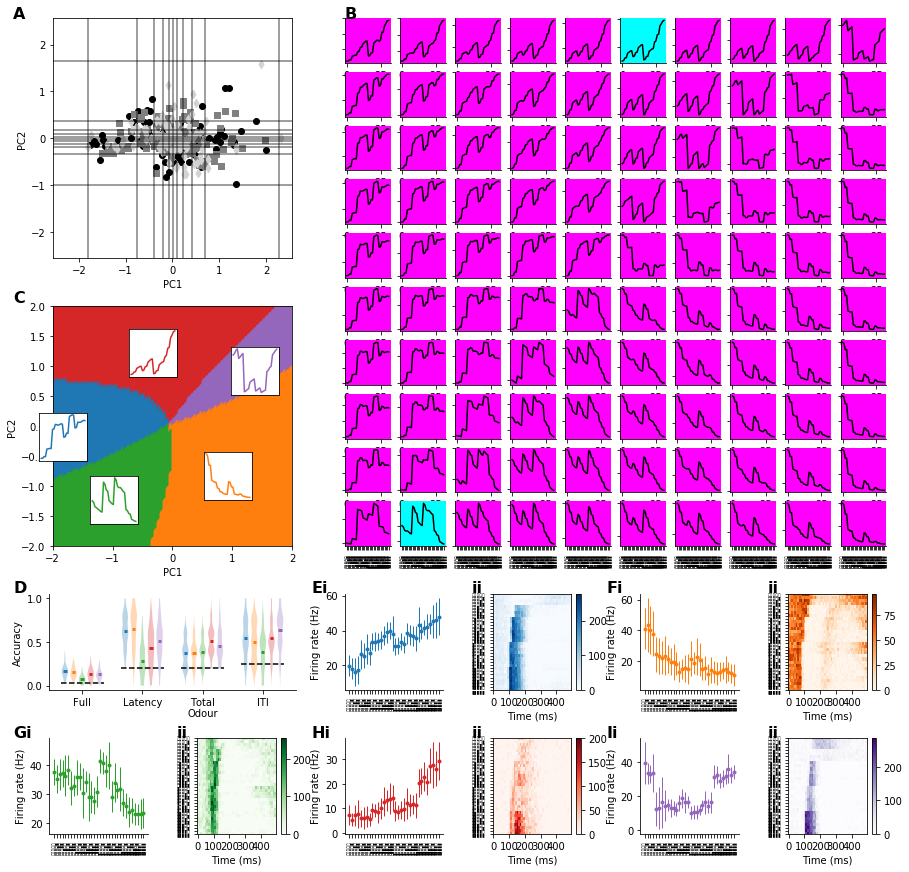

In [12]:
## Figure plotting - needs to be run TWICE because I calculate the scaling for B
## after plotting 

fig = plt.figure(figsize=(15, 15))
gs = GridSpec(6, 6, figure=fig, hspace=0.5, wspace=0.5)

### The response map ax (part B)
response_map_ax = fig.add_subplot(gs[:4, 2:], frameon=False)
response_map_ax.set_xticks([])
response_map_ax.set_yticks([])

max_counts = plot_response_map(fig, gs[:4, 2:], max_counts)

### Make the axis for part A, the scatter plot
pc_ax = fig.add_subplot(gs[:2, :2], aspect='equal')
plot_scatter_and_pos(pc_ax)

### Make the axis for the archetypes (part C)
arc_ax = fig.add_subplot(gs[2:4, :2], aspect='equal')
plot_archetypes(arc_ax, all_pred_fits)

### Make the axis for the violin plots (part D)
violin_ax = fig.add_subplot(gs[4, :2])
plot_acc_violins(violin_ax)

### Make the axis for the example cell responses (part E-I)
examp_ax11 = fig.add_subplot(gs[4, 2])
examp_ax12 = fig.add_subplot(gs[4, 3])
examp_ax21 = fig.add_subplot(gs[4, 4])
examp_ax22 = fig.add_subplot(gs[4, 5])
examp_ax31 = fig.add_subplot(gs[5, 0])
examp_ax32 = fig.add_subplot(gs[5, 1])
examp_ax41 = fig.add_subplot(gs[5, 2])
examp_ax42 = fig.add_subplot(gs[5, 3])
examp_ax51 = fig.add_subplot(gs[5, 4])
examp_ax52 = fig.add_subplot(gs[5, 5])
plot_selected_cell_response(unit_usrt_j, 348, ax=examp_ax11, color='C0')
plot_selected_cell_heatmap(unit_usrt_j, 348, ax=examp_ax12, cmap='Blues')
plot_selected_cell_response(unit_usrt_j, 162, ax=examp_ax21, color='C1')
plot_selected_cell_heatmap(unit_usrt_j, 162, ax=examp_ax22, cmap='Oranges')
plot_selected_cell_response(unit_usrt_j, 233, ax=examp_ax31, color='C2')
plot_selected_cell_heatmap(unit_usrt_j, 233, ax=examp_ax32, cmap='Greens')
plot_selected_cell_response(unit_usrt_j, 50, ax=examp_ax41, color='C3')
plot_selected_cell_heatmap(unit_usrt_j, 50, ax=examp_ax42, cmap='Reds')
plot_selected_cell_response(unit_usrt_j, 37, ax=examp_ax51, color='C4')
plot_selected_cell_heatmap(unit_usrt_j, 37, ax=examp_ax52, cmap='Purples')

### Label the axes
axes = [pc_ax, response_map_ax, arc_ax, violin_ax, examp_ax11, examp_ax12, examp_ax21, examp_ax22, examp_ax31, examp_ax32, examp_ax41, examp_ax42, examp_ax51, examp_ax52]
labels = ['A', 'B', 'C', 'D', 'Ei', 'ii', 'Fi', 'ii', 'Gi', 'ii', 'Hi', 'ii', 'Ii', 'ii']
align_x = [[0, 2, 3, 8], [5, 11], [6, 12], [7, 13]]
align_y = [[0, 1], [3, 4, 5, 6, 7], [8, 9, 10, 11, 12, 13]]
label_axes.label_axes(axes, labels, fontsize=16, fontweight='bold', align_x=align_x, align_y=align_y)
#plt.savefig('230703_fig6.pdf', bbox_inches='tight')

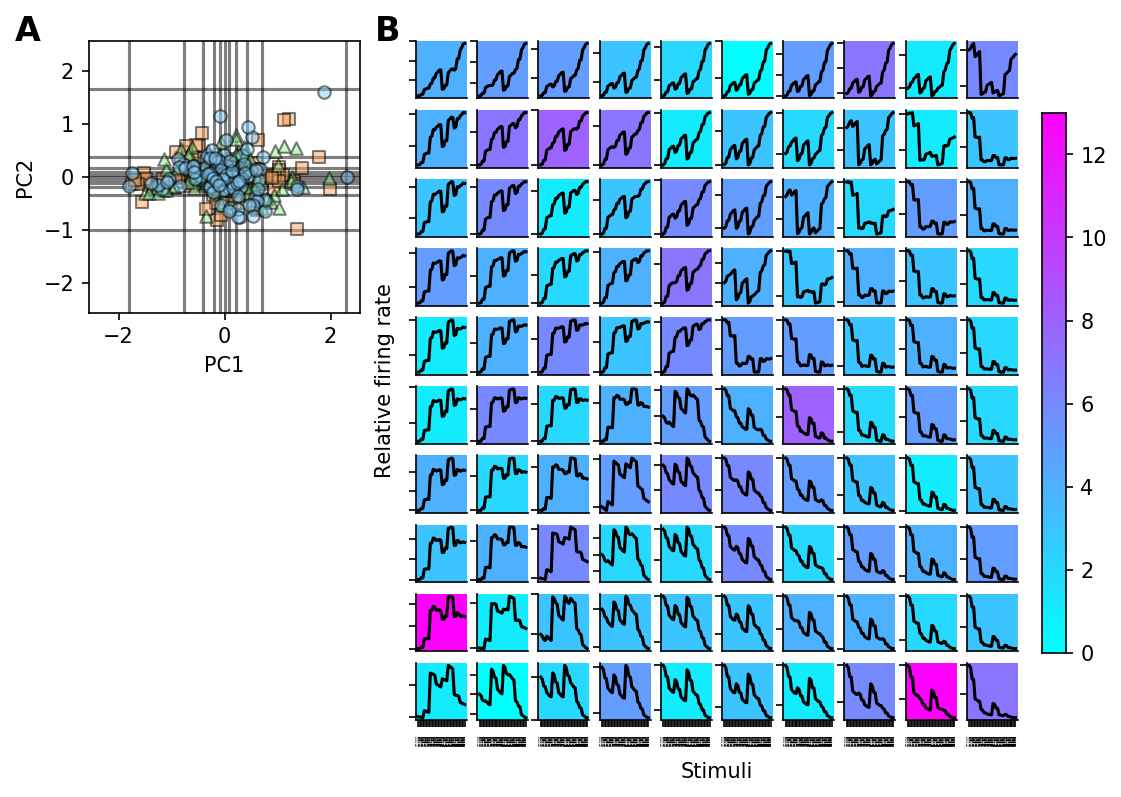

In [45]:
fig = plt.figure(figsize=(8, 6), dpi=150)
gs = GridSpec(2, 6, figure=fig, hspace=0.5, wspace=0.5)

### The response map ax (part B)
response_map_ax = fig.add_subplot(gs[:, 2:], frameon=False)
response_map_ax.set_xticks([])
response_map_ax.set_yticks([])

max_counts = plot_response_map(fig, gs[:, 2:], max_counts, fs=2)

### Make the axis for part A, the scatter plot
pc_ax = fig.add_subplot(gs[0, :2], aspect='equal')
plot_scatter_and_pos(pc_ax)
response_map_ax.set_ylabel('Relative firing rate', labelpad=10)
response_map_ax.set_xlabel('Stimuli', labelpad=20)
axes = [pc_ax, response_map_ax]
labels = ['A', 'B']
align_y = [[0, 1]]
label_axes.label_axes(axes, labels, align_y=align_y, fontsize=16, fontweight='bold')
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])
cbar_ax.imshow(np.linspace(0, max_counts, 1000)[::-1, None], cmap='cool', aspect='auto', extent=[0, 0.5, 0, max_counts])
cbar_ax.yaxis.tick_right()
cbar_ax.set_xticks([])
plt.savefig('230912_Sup61.pdf', bbox_inches='tight')